In [1]:
%matplotlib inline
%autosave 5

Autosaving every 5 seconds


In [7]:
# necessary modules -------------------------------------------------------------------------------------
import pyfesom2 as pf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import time
from datetime import date

#import sys
#sys.path.append('home/ollie/mozeisin/SkillMetrics')

#import cartopy.crs as ccrs
#import pangaeapy.pandataset as pd

# own py_recom modules ----------------------------------------------------------------------
#!jupyter nbconvert --to=python plot_Taylor_normalized.ipynb

#from load_interp_WOA_python3 import WOAdata
from plot_Taylor_normalized import plt_Taylor_norm

In [53]:
# After changing these parameters here, save the notebook and clear the output. 
# Then run this cell and the cells with the desired parameters.

# run specification -------------------------------------------------------------------------------------
runid      =  'fesom'
layerwise    = False
resultpath = '/work/ollie/mozeisin/results/f2r1.2/20201015_tep_test' 
meshpath = '/work/ollie/mozeisin/mesh/mesh_fesom2.0/core2_meanz'

# period of analysis 
first_year = 1949
last_year  = 1950
    
years = [first_year, last_year]

# specification of analysis ------------------------------------------------------------------------------------
depth = 5
layerwise = False
mapproj = 'pc'
#Map projection. Options are Mercator (merc), Plate Carree (pc),
#North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
#Robinson projection is quite time consuming.

# export of analysis ------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")

savepath = '/home/ollie/mozeisin/evaluation/mo_files/tep_test/'
savefig = False
htmlname     =  runid + today +'.html'
htmlpath = '/home/ollie/mozeisin/evaluation/mo_files/html/'
    

In [54]:
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)

# Intracellular carbon

Model depth: 5.0


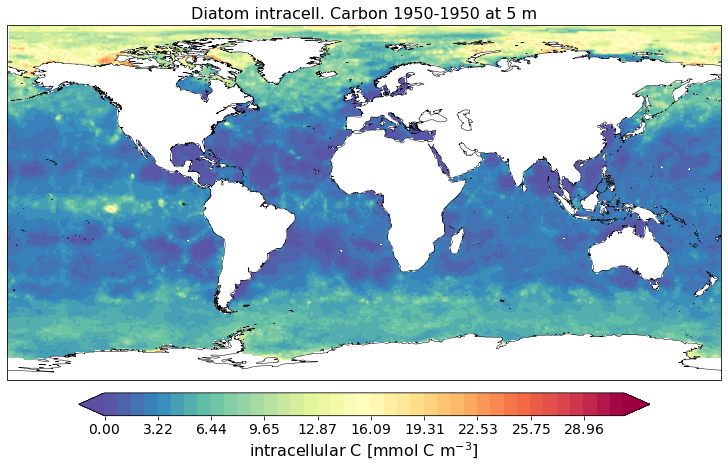

In [38]:
# Diatom carbon

NCfesom = resultpath + '/DiaC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Diatom intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
DiaC = pf.get_data(resultpath, "DiaC", years=1950, mesh=mesh, runid=runid, how="mean", depth=depth)
fig = pf.plot(mesh, DiaC, mapproj = mapproj, units=units, titles=label)


Model depth: 5.0


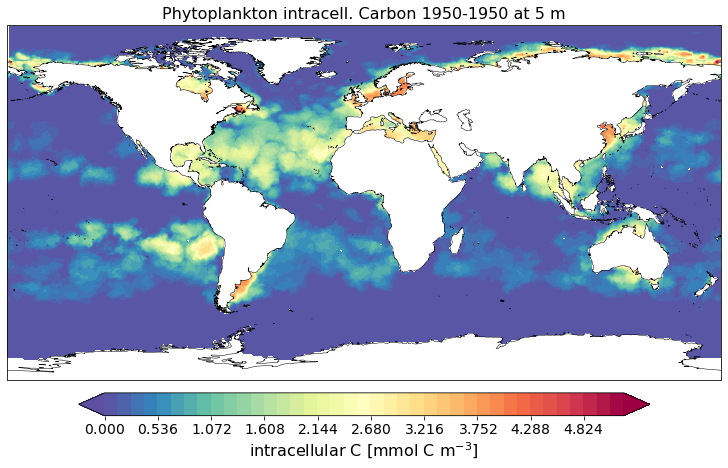

In [40]:
# Phytplankton carbon

NCfesom = resultpath + '/PhyC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Phytoplankton intracell. Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'intracellular C [mmol C m$^{-3}$]'
PhyC = pf.get_data(resultpath, "PhyC", years=1950, mesh=mesh, runid=runid, how="mean", depth = depth)
fig = pf.plot(mesh, PhyC, mapproj = mapproj, units=units, titles=label)


# TEP stuff

In [75]:
label='Polysaccharides {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'org C [mmol m$^{-3}$]'
PCHO = pf.get_data(resultpath, "PCHO", years=years, mesh=mesh, runid=runid, how="mean")#, depth=depth)

print(np.shape(PCHO))
print('PCHO loaded for years {0}-{1}\nmin = {3}, max = {4}, mean = {5} [mmol/m3]'.format(
    years[0],years[1],depth, np.nanmin(PCHO), np.nanmax(PCHO), np.nanmean(PCHO)))

Depth is None, 3d field will be returned
(126858, 47)
PCHO loaded for years 1949-1950
min = 0.0, max = 2.230026256581555e-16, mean = 1.3860746563706884e-16 [mmol/m3]


Plotting transect at lat -80 to 80, lon -25 to -25


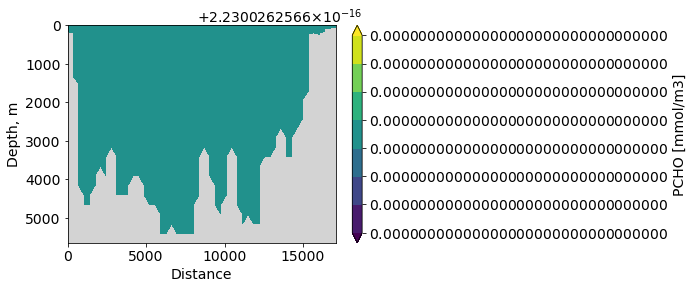

In [72]:
# Atlantic transect ------------------------------------------------------------------------------
lon_start = -25
lat_start = -80
lon_end = -25
lat_end = 80
npoints   = 50
lonlat = pf.transect_get_lonlat(lon_start, lat_start, lon_end, lat_end, npoints)

print('Plotting transect at lat {0} to {1}, lon {2} to {3}'.format(lat_start,lat_end,lon_start,lon_end))
#pf.plot_transect_map(lonlat, mesh)

dist, tfPCHO = pf.get_transect(PCHO,mesh,lonlat)

pf.plot_xyz(mesh, 
            tfPCHO,
            dist,
            maxdepth=6000,
            ncols=1,
            xlabel='Distance',
            label='PCHO [mmol/m3]',
            #levels=np.linspace(-2,2, 41),
            cmap='viridis',
            figsize=(15, 6))

ValueError: Contour levels must be increasing

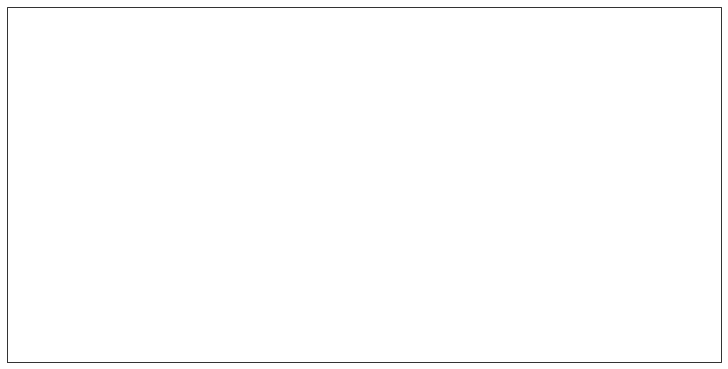

In [74]:
fig = pf.plot(mesh, PCHO[:,2], mapproj = mapproj, units=units, titles=label)

Model depth: 5.0


ValueError: Contour levels must be increasing

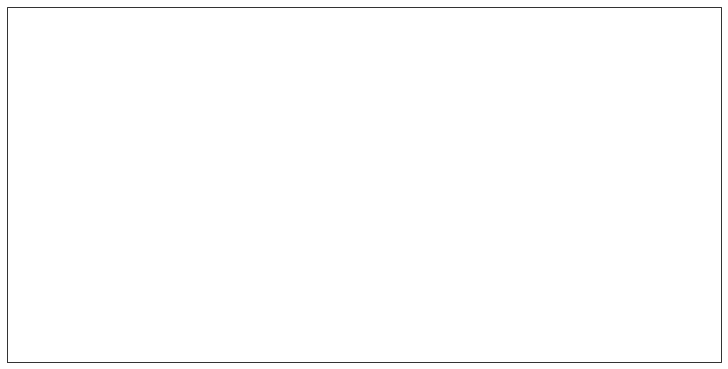

In [19]:
label='TEP {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'TEP-C [mmol m$^{-3}$]'
TEP = pf.get_data(resultpath, "TEP", years, mesh, runid=runid, how="mean", compute=True, depth=5)
fig = pf.plot(mesh, TEP, mapproj = mapproj, units=units, titles=label)

# GPP

Model depth: 5.0


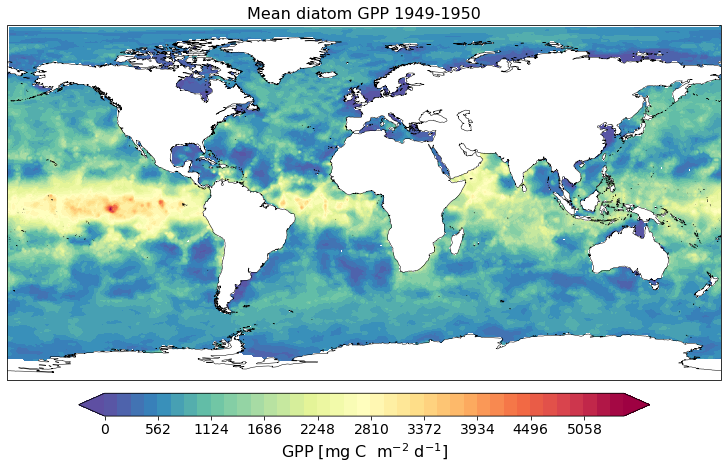

In [20]:
# Diatom GPP

NCfesom = resultpath + '/GPPd.fesom.1948.nc'
#!ncdump -h $NCfesom

# 12.01* data --> mg C/m2/d

label='Mean diatom GPP {0}-{1}'.format(years[0],years[1])
units = 'GPP [mg C  m$^{-2}$ d$^{-1}$]'
GPPd = pf.get_data(resultpath, "GPPd", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
GPPd = GPPd * 12.01
fig = pf.plot(mesh, GPPd, mapproj = mapproj, units=units, titles=label)


# DIC

Model depth: 5.0


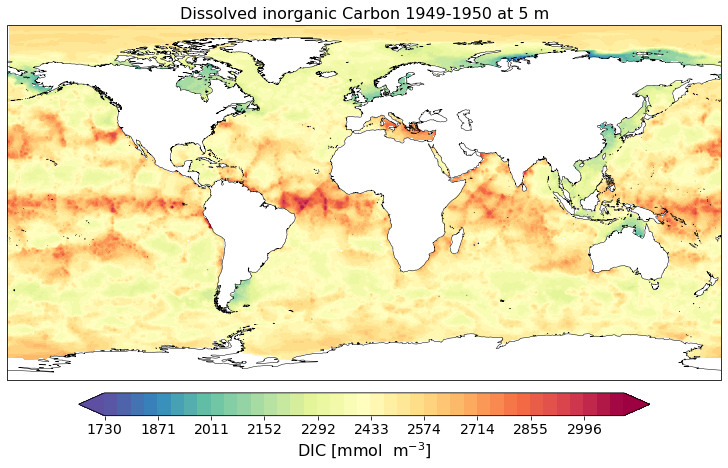

In [21]:
# DIC

NCfesom = resultpath + '/DIC.fesom.1948.nc'
#!ncdump -h $NCfesom

label='Dissolved inorganic Carbon {0}-{1} at {2} m'.format(years[0],years[1],depth)
units = 'DIC [mmol  m$^{-3}$]'
DIC = pf.get_data(resultpath, "DIC", years, mesh, runid=runid, how="mean", compute=True, depth=depth)
fig = pf.plot(mesh, DIC, mapproj = mapproj, units=units, titles=label)


# export to html

In [ ]:
%autosave 2

time.sleep(15)

!jupyter nbconvert MASTER_Script_python3.ipynb --output-dir=$htmlpath --output $htmlname --to html 